# PCA on High-Level Dimensions

In [30]:
import pandas as pd
import numpy as np
from IPython.display import display
import re
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Helper Functions

In [23]:
def clean_rsi(value):
    """Converts various RSI string formats to a single float, or NaN."""
    if pd.isna(value) or value == 'Not Specified':
        return np.nan
    value_str = str(value)
    if "Varied (choice:" in value_str:
        numbers = [float(x) for x in re.findall(r'\d+', value_str)]
        return np.mean(numbers) if numbers else np.nan
    elif "Varied (Uniform:" in value_str:
        numbers = [float(x) for x in re.findall(r'\d+', value_str)]
        return np.mean(numbers) if len(numbers) == 2 else np.nan
    try:
        return float(value_str)
    except (ValueError, TypeError):
        return np.nan

def clean_switch_rate(value):
    """Converts switch rate percentages (as strings) to floats."""
    if pd.isna(value):
        return 0.0  # Assume 0 if not specified
    value_str = str(value).replace('%', '').strip()
    try:
        return float(value_str)
    except (ValueError, TypeError):
        return 0.0

def classify_paradigm(row):
    # This function now reliably receives numeric inputs
    if row['Number of Tasks'] == 2:
        return 'Dual-Task/PRP'
    if row['Switch Rate'] > 0:
        return 'Task Switching'
    if row['Number of Tasks'] == 1 and not pd.isna(row['SOA']):
        return 'Interference'
    return 'Other' # This seems to only apply to Schroeter et al.

# --- STAGE 1: General Preprocessing ---
def general_preprocess(df_raw):
    """
    Performs general data cleaning on the raw DataFrame, converting strings to
    numbers and handling initial missing values. Returns a cleaned DataFrame
    suitable for various types of analysis.
    """
    print("\n--- Running Stage 1: General Preprocessing ---")
    df_cleaned = df_raw.copy()

    # Convert key columns to numeric types
    df_cleaned['Number of Tasks'] = pd.to_numeric(df_cleaned['Number of Tasks'], errors='coerce')
    df_cleaned['SOA'] = pd.to_numeric(df_cleaned['SOA'], errors='coerce')
    df_cleaned['CSI'] = pd.to_numeric(df_cleaned['CSI'], errors='coerce')
    df_cleaned['Task 1 Difficulty'] = pd.to_numeric(df_cleaned['Task 1 Difficulty'], errors='coerce')
    df_cleaned['Task 2 Difficulty'] = pd.to_numeric(df_cleaned['Task 2 Difficulty'], errors='coerce')

    # Apply custom cleaning functions
    df_cleaned['RSI'] = df_cleaned['RSI'].apply(clean_rsi)
    df_cleaned['Switch Rate'] = df_cleaned['Switch Rate'].apply(clean_switch_rate)

    # Impute missing RSI values with the column median
    rsi_median = df_cleaned['RSI'].median()
    df_cleaned['RSI'].fillna(rsi_median, inplace=True)
    print(f"Cleaned raw data. Imputed missing RSI values with median: {rsi_median:.2f}")
    
    print("General preprocessing complete.")
    return df_cleaned

# --- STAGE 2: Create Features for PCA ---
def create_pca_features(df_cleaned):
    """
    Takes the cleaned DataFrame and engineers the final features for PCA,
    including normalization and mapping categorical variables.
    """
    print("\n--- Running Stage 2: Creating PCA-Specific Features ---")
    df_pca_ready = df_cleaned.copy()

    # Handle N/A values in a PCA-compatible way. The largest negative value found in the dataset
    # for SOA is -100, indicating a distractor appearing before the target. I've chosen -9999 to
    # serve as the "N/A" placeholder for SOA. I'm not sure how else to handle this.
    df_pca_ready['SOA'].fillna(-9999, inplace=True) 
    print("Imputed N/A SOA values with -9999 as a unique placeholder.")
    df_pca_ready['CSI'].fillna(0, inplace=True) # Use 0 for N/A CSIs

    # Normalize Task Difficulty (1-5 scale to 0-1)
    df_pca_ready['Task 1 Difficulty'] = (df_pca_ready['Task 1 Difficulty'] - 1) / 4
    df_pca_ready['Task 2 Difficulty'] = (df_pca_ready['Task 2 Difficulty'] - 1) / 4
    
    # Impute missing difficulty and handle N_Tasks=1 case
    # the below should never actually happen since there should always be a difficulty
    # for task 1
    df_pca_ready['Task 1 Difficulty'].fillna(0.5, inplace=True)
    df_pca_ready.loc[df_pca_ready['Number of Tasks'] == 1, 'Task 2 Difficulty'] = -1
    # the below should also never happen because task 2 difficulties that were "N/A"
    # should have been imputed as -1 because those are exactly the conditions where 
    # there is only one task (handled by the line above)
    df_pca_ready['Task 2 Difficulty'].fillna(0.5, inplace=True)
    print("Normalized Task Difficulty scores.")

    # --- Map Conceptual Categorical Features for One-Hot Encoding ---
    def map_valency(val):
        val_str = str(val).lower()
        if 'univalent' in val_str: return 'SBC_Univalent'
        if 'incongruent' in val_str: return 'SBC_Bivalent_Congruent'
        if 'congruent' in val_str: return 'SBC_Bivalent_Incongruent'
        if 'neutral' in val_str: return 'SBC_Bivalent_Neutral'
        return 'SBC_NA'
    df_pca_ready['Stimulus_Valency_Mapped'] = df_pca_ready['Stimulus Valency'].apply(map_valency)

    def map_rso(val):
        val_str = str(val).lower()
        if 'identical' in val_str: return 'RSO_Identical'
        if 'disjoint' in val_str: return 'RSO_Disjoint'
        return 'RSO_NA'
    df_pca_ready['Response_Set_Overlap_Mapped'] = df_pca_ready['Response Set Overlap'].apply(map_rso)

    def map_srm(val):
        val_str = str(val).lower()
        if 'incompatible' in val_str: return 'SRM_Compatible'
        if 'compatible' in val_str: return 'SRM_Incompatible'
        if 'arbitrary' in val_str: return 'SRM_Arbitrary'
        return 'SRM_NA'
    df_pca_ready['Stimulus_Response_Mapping_Mapped'] = df_pca_ready['Stimulus Response Mapping'].apply(map_srm)
    
    def map_tct(val):
        val_str = str(val).lower()
        if 'arbitrary' in val_str:
            return 'TCT_Arbitrary'
        # Default to Implicit for "None/Implicit" and any NaN values
        return 'TCT_Implicit' 
    
    df_pca_ready['Task_Cue_Type_Mapped'] = df_pca_ready['CSI'].apply(map_tct)
    print("Mapped categorical features to simplified categories for encoding.")

    # --- Select final columns for PCA pipeline ---
    numerical_cols = ['Number of Tasks', 'SOA', 'CSI', 'RSI', 'Switch Rate', 'Task 1 Difficulty', 'Task 2 Difficulty']
    categorical_cols = ['Stimulus_Valency_Mapped', 'Response_Set_Overlap_Mapped', 'Stimulus_Response_Mapping_Mapped', 'Task_Cue_Type_Mapped']
    
    pca_input_df = df_pca_ready[numerical_cols + categorical_cols]
    
    print("PCA feature creation complete.")
    print(pca_input_df["Stimulus_Response_Mapping_Mapped"].unique())
    return pca_input_df, numerical_cols, categorical_cols

### Exploratory Data Analysis

In [24]:
try:
    df_raw = pd.read_csv('./data/super_experiment_design_space.csv')
    print("Successfully loaded the dataset.")
    print(f"Original shape: {df_raw.shape}")
except FileNotFoundError:
    print("Error: './data/super_experiment_design_space.csv' not found.")
    exit()

# 2. Perform General Preprocessing
df_cleaned = general_preprocess(df_raw)

print("\n--- Running Stage 2: Exploratory Analysis of Categorical Variables ---")
print("Analyzing value counts to inform PCA feature mapping decisions.")
print("-" * 60)

# List of the original categorical columns we want to inspect
categorical_columns_to_explore = [
    'Response Set Overlap',
    'Stimulus Valency',
    'Stimulus Response Mapping',
    'Task Cue Type'
]

# Loop through the columns and print their value counts
for col in categorical_columns_to_explore:
    print(f"\nValue counts for column: '{col}'")
    # Use dropna=False to explicitly see the count of any missing values (NaNs)
    print(df_cleaned[col].value_counts(dropna=False))
    print("-" * 30)

print("-" * 60)
print("Review the counts above. If a sub-category has very few examples (e.g., < 5-10),")
print("it is generally better to collapse it into a broader category for the PCA.")
print("This analysis should guide the modifications to the mapping functions in Stage 3.")

Successfully loaded the dataset.
Original shape: (161, 16)

--- Running Stage 1: General Preprocessing ---
Cleaned raw data. Imputed missing RSI values with median: 1000.00
General preprocessing complete.

--- Running Stage 2: Exploratory Analysis of Categorical Variables ---
Analyzing value counts to inform PCA feature mapping decisions.
------------------------------------------------------------

Value counts for column: 'Response Set Overlap'
Response Set Overlap
NaN                                    66
Identical                              63
Disjoint - Category (Same Modality)    10
Disjoint - Modality (Standard)          6
Disjoint - Effector                     6
Disjoint - Modality                     5
Disjoint - Modality (Non-Standard)      5
Name: count, dtype: int64
------------------------------

Value counts for column: 'Stimulus Valency'
Stimulus Valency
Bivalent-Neutral                         44
Bivalent-Incongruent                     38
Univalent                  

In [25]:
df_cleaned['Paradigm'] = df_cleaned.apply(classify_paradigm, axis=1)
print("\nClassified paradigms into conceptual groups for visualization.")


Classified paradigms into conceptual groups for visualization.


## PCA

In [26]:
pca_input_df, numerical_cols, categorical_cols = create_pca_features(df_cleaned)

# 5. Create and Run PCA Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
    ],
    remainder='passthrough'
)

pca_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA())
])

print("\nRunning PCA...")
pca_pipeline.fit(pca_input_df)
pca = pca_pipeline.named_steps['pca']
preprocessor_fitted = pca_pipeline.named_steps['preprocessor']

ohe_feature_names = preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(ohe_feature_names)

print("PCA fitting complete.")


--- Running Stage 2: Creating PCA-Specific Features ---
Imputed N/A SOA values with -9999 as a unique placeholder.
Normalized Task Difficulty scores.
Mapped categorical features to simplified categories for encoding.
PCA feature creation complete.
['SRM_Arbitrary' 'SRM_Incompatible' 'SRM_Compatible']

Running PCA...
PCA fitting complete.


### PCA Results

In [27]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print("\n--- PCA Results ---")
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
    print(f"PC{i+1}: Explained Variance = {var:.3f}, Cumulative Variance = {cum_var:.3f}")

# Component Loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(explained_variance))],
    index=all_feature_names
)
print("\n--- Principal Component Loadings ---")
print(loadings.round(3).to_string())


--- PCA Results ---
PC1: Explained Variance = 0.295, Cumulative Variance = 0.295
PC2: Explained Variance = 0.169, Cumulative Variance = 0.464
PC3: Explained Variance = 0.157, Cumulative Variance = 0.622
PC4: Explained Variance = 0.119, Cumulative Variance = 0.740
PC5: Explained Variance = 0.113, Cumulative Variance = 0.853
PC6: Explained Variance = 0.059, Cumulative Variance = 0.913
PC7: Explained Variance = 0.030, Cumulative Variance = 0.943
PC8: Explained Variance = 0.022, Cumulative Variance = 0.965
PC9: Explained Variance = 0.010, Cumulative Variance = 0.975
PC10: Explained Variance = 0.007, Cumulative Variance = 0.982
PC11: Explained Variance = 0.006, Cumulative Variance = 0.988
PC12: Explained Variance = 0.005, Cumulative Variance = 0.993
PC13: Explained Variance = 0.003, Cumulative Variance = 0.996
PC14: Explained Variance = 0.002, Cumulative Variance = 0.999
PC15: Explained Variance = 0.001, Cumulative Variance = 1.000

--- Principal Component Loadings ---
                    

### Experimental Conditions Mapped Onto First Two Principal Components


Generating visualization...


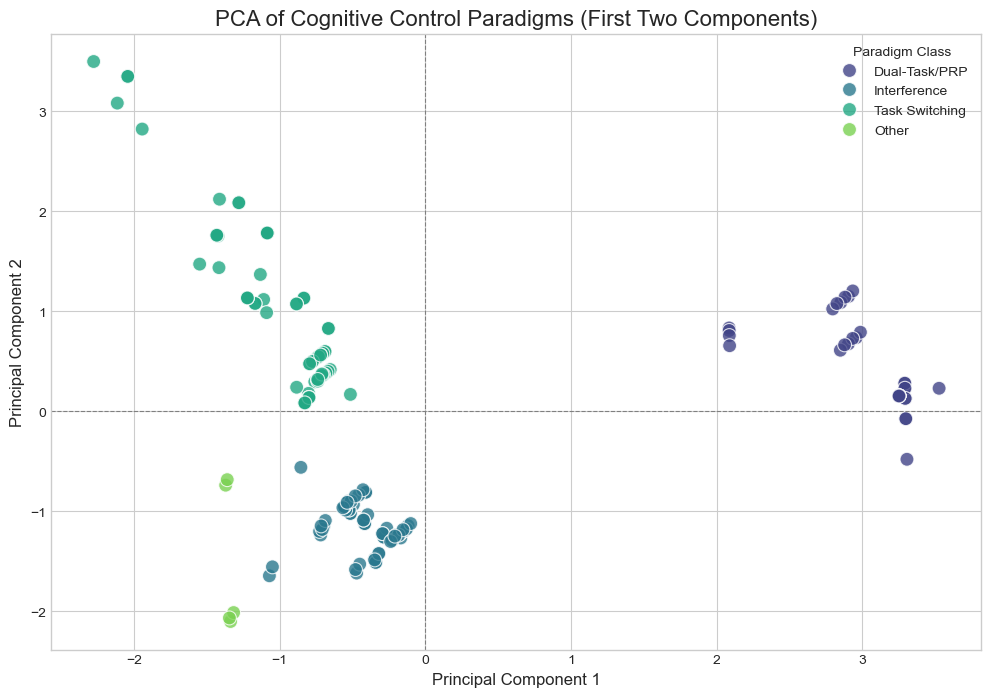

In [28]:
print("\nGenerating visualization...")
pca_result = pca_pipeline.transform(pca_input_df)
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
# Add the paradigm classification from the cleaned df for coloring
pca_df['Paradigm'] = df_cleaned['Paradigm'].values

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Paradigm',
    palette='viridis',
    alpha=0.8,
    s=100,
    ax=ax
)

ax.set_title('PCA of Cognitive Control Paradigms (First Two Components)', fontsize=16)
ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)
ax.axhline(0, color='grey', linestyle='--', linewidth=0.8)
ax.axvline(0, color='grey', linestyle='--', linewidth=0.8)
plt.legend(title='Paradigm Class')
plt.savefig("./fig.png")
plt.show()